In [1]:
#coding=utf-8
import gdal
import os
import numpy as np
import argparse
from PIL import Image  
import cv2
import random
from tqdm import tqdm  
import time
import gdal
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
# data for training  
from Models import *
from Models.SegNet2In import *
from Models.utils import *
import argparse
import numpy as np 
from keras import backend as K 
from keras import *
from keras.applications import vgg16
from keras.layers import *
from keras.utils.np_utils import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.preprocessing.image import img_to_array
from keras.models import *
from keras import backend as K 
from sklearn.preprocessing import *
from plot_cm import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
matplotlib.use("Agg")

Using TensorFlow backend.


In [2]:
def bandScale(band):
    return band/(np.max(band))
def predict2input(key,stride=256):
    method = {'SegNet2In_2':SegNet2In_2}
    print("[INFO] loading network model...")
    try:
        model = load_model('D:\Python\seg-data/model/%s_model.h5' % key)
    except:
        model = method[key]() # 有自定义层时，不能直接加载模型
        model.load_weights('D:\Python\seg-data/model/%s_model.h5' % key)
    print('[INFO] model loaded')
    #print(model.get_weights()) #  [['test_10m_roi.tif'],['test_20m_roi.tif']],[['test_10m_roi.png'],['test_20m_roi.png']]
    image_size=stride
    TEST_SET_10=['test_10m_roi']
    TEST_SET_20=['test_20m_roi']
    predir=r'D:\Python\seg-data\data_MB/'
    for n in range(len(TEST_SET_20)):
        tif_img20 = gdal.Open(predir+TEST_SET_20[n]+'.tif')
        tif_w20 = tif_img20.RasterXSize #栅格矩阵的列数
        tif_h20 = tif_img20.RasterYSize
        tif_data20=tif_img20.ReadAsArray(0,0,tif_w20,tif_h20)
        tif_d20=tif_data20.shape[0]
        tif_data20=np.array(tif_data20[0:3], dtype=float)
        
        tif_img10 = gdal.Open(predir+TEST_SET_10[n]+'.tif')
        tif_w10 = tif_img10.RasterXSize #栅格矩阵的列数
        tif_h10 = tif_img10.RasterYSize
        tif_data10=tif_img10.ReadAsArray(0,0,tif_w10,tif_h10)
        tif_d10=tif_data10.shape[0]
        tif_data10=np.array(tif_data10, dtype=float)
        
        plt.imshow(tif_data10[0],cmap='gray')
        plt.show()
        plt.imshow(tif_data20[0],cmap='gray')
        plt.show()
        image10=cv2.merge((bandScale(tif_data10[0]),
                           bandScale(tif_data10[1]),
                           bandScale(tif_data10[2]),
                           bandScale(tif_data10[3])))
        h10,w10,_10 = image10.shape
        image20=cv2.merge((bandScale(tif_data20[0]),
                           bandScale(tif_data20[1]),
                           bandScale(tif_data20[2])))                 
        h20,w20,_20 = image20.shape
        
        padding_h20 = (h20//(stride//2) + 1) * (stride//2)
        padding_w20 = (w20//(stride//2) + 1) * (stride//2)
        padding_img20 = np.zeros((padding_h20,padding_w20,_20))
        padding_img20[0:h20,0:w20,:] = image20[:,:,:]

        #mask_whole20 = np.zeros((padding_h20,padding_w20))
        
        padding_h10 = (h10//stride + 1) * stride 
        padding_w10 = (w10//stride + 1) * stride
        padding_img10 = np.zeros((padding_h10,padding_w10,_10))
        padding_img10[0:h10,0:w10,:] = image10[:,:,:]
        mask_whole10 = np.zeros((padding_h10,padding_w10))
        
        for i in range(padding_h10//stride):
            for j in range(padding_w10//stride):
                crop10 = padding_img10[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
                #(crop101,crop102,crop103,crop104)=cv2.split(crop10)
                #plt.imshow(crop101*255,cmap='gray')
                #plt.show()
                
                crop20 = padding_img20[i*128:i*128+128,j*128:j*128+128,:]
                #(crop201,crop202,crop203,crop204,crop205,crop206)=cv2.split(crop20)
                #plt.imshow(crop201*255,cmap='gray')
                #plt.show()
                
                ch10,cw10,_10 = crop10.shape
                if (ch10 != 256 or cw10 != 256):
                    print ('invalid size!')
                    continue
                crop10 = np.expand_dims(crop10, axis=0)
                #print(crop10,crop20,"\n ################################# \n")
                crop20 = np.expand_dims(crop20, axis=0)
                crop=[crop10 , crop20]
                try:                    
                    pred = model.predict_classes(crop,verbose=0)
                    pred_prob = model.predict_proba(crop,verbose=1)
                    #print ('[INFO]Trying\n')
                except AttributeError as e:
                    pred = model.predict(crop,verbose=2)
                    #print('[INFO]Except\n')
                    pred=np.argmax(model.predict(crop,verbose=2),axis=2).astype(np.float) 
                   
                    
                
                pred = pred.reshape(256,256)
                mask_whole10[i*stride:i*stride+image_size,j*stride:j*stride+image_size] = pred[:,:]

                #cv2.imwrite('./pre-img/pre'+str(i+1)+"-"+str(j+1)+'.png',pred*255)
    cv2.imwrite('./pre-img/pre.png',mask_whole10[0:h10,0:w10]*255)
    y_true=cv2.imread('D:\Python\seg-data\data_MB/' + TEST_SET_10[0]+'.png',cv2.IMREAD_GRAYSCALE)
    #print(y_true.flatten().shape,mask_whole[0:h,0:w].flatten().shape)
    plot_confusion_matrix(y_true.flatten(), mask_whole10[0:h10,0:w10].flatten(),[ 0,1])
    plt.imshow(mask_whole10*255,cmap='gray')

[INFO] loading network model...
[INFO] model loaded


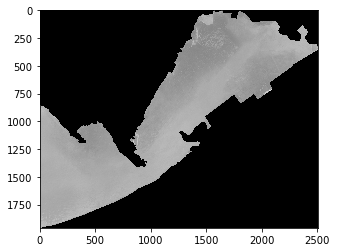

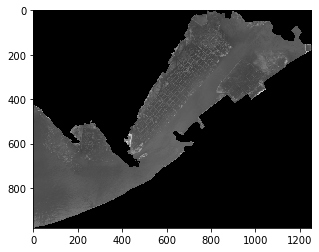

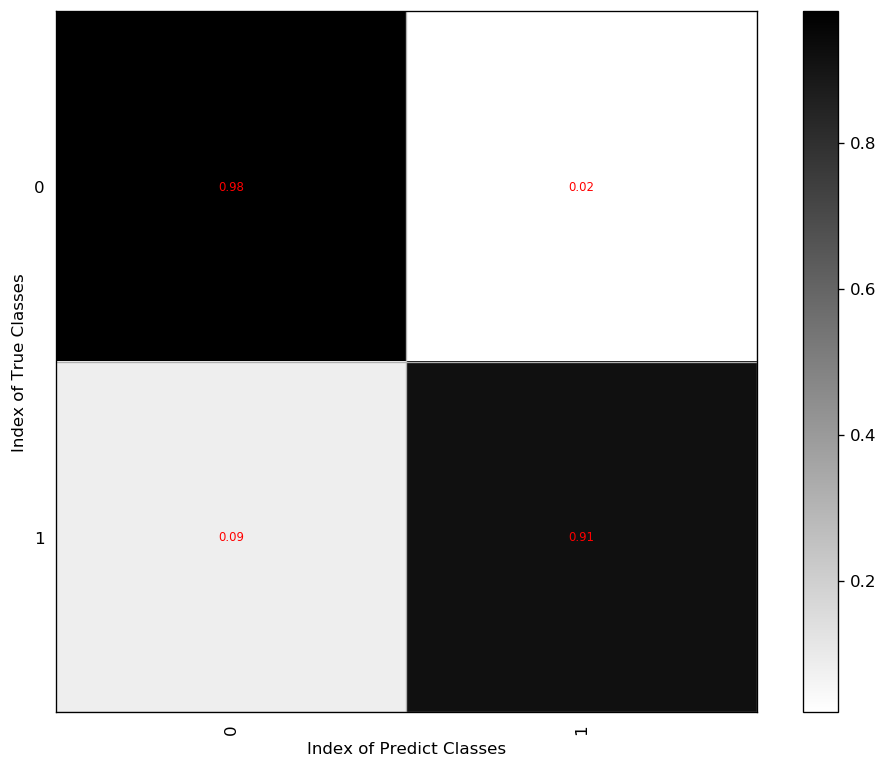


 Pixel_Accuracy: 0.9737437370157644 
 Pixel_Accuracy_Class: 0.947472541137504 
 Mean_Intersection_over_Union: 0.8726059875351208 
 Class_IOU: [0.97 0.77]


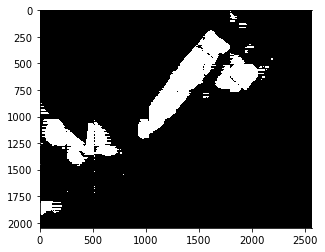

In [3]:
%matplotlib inline
predict2input(key='SegNet2In_2',stride=256)